# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

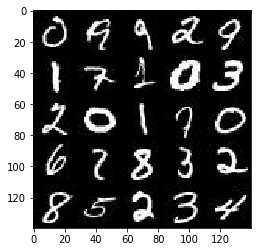

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

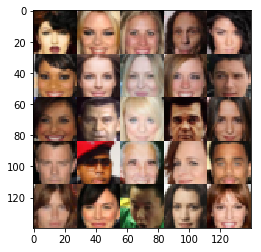

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_image = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))
    z_input = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return real_image, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
tf.reset_default_graph()

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = .2
    with tf.variable_scope('discriminator', reuse=reuse):
        # first convolution
        conv1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * conv1, conv1)
        assert conv1.get_shape()[1:] == (14, 14, 128), conv1.get_shape()
        
        conv2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * conv2, conv2)
        assert conv2.get_shape()[1:] == (7, 7, 256), conv2.get_shape()
        
        conv3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * conv3, conv3)
        assert conv3.get_shape()[1:] == (4, 4, 512), conv3.get_shape()

        # Flatten it
        flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
tf.reset_default_graph()
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = .2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        conv1 = tf.layers.dense(z, 2 * 2 * 512)
        
        # first deconvolution
        conv1 = tf.reshape(conv1, (-1, 2, 2, 512))
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        assert conv1.get_shape()[1:] == (2, 2, 512), conv1.get_shape()
        
        # second deconvolution
        conv2 = tf.layers.conv2d_transpose(conv1, 256, 5, strides=2, padding='valid')
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
        assert conv2.get_shape()[1:] == (7, 7, 256), conv2.get_shape()
        
        # third deconvolution
        conv3 = tf.layers.conv2d_transpose(conv2, 128, 5, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=is_train)
        conv3 = tf.maximum(alpha * conv3, conv3)
        assert conv3.get_shape()[1:] == (14, 14, 128), conv3.get_shape()
        
        # Output layer
        logits = tf.layers.conv2d_transpose(conv3, out_channel_dim, 5, strides=2, padding='same')
        assert logits.get_shape()[1:] == (28, 28, out_channel_dim), logits.get_shape()
        
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = .9
    
    # Build the model
    g_model = generator(input_z, out_channel_dim, is_train=True)
    # g_model is the generator output

    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    
    # Calculate losses
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_logits_real) * smooth))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_logits_fake) * smooth))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            d_losses = []
            g_losses = []
            for b, batch_images in enumerate(get_batches(batch_size)):
                # TODO: Train Model
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _, dis_loss = sess.run([d_train_opt, d_loss], feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _, gen_loss = sess.run([g_train_opt, g_loss], feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                d_losses.append(dis_loss)
                g_losses.append(gen_loss)
                
                print('Batch: {} - Discriminator Loss: {} - Generator Loss: {}'.format(b, dis_loss, gen_loss))
                
                if b % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Batch: 0 - Discriminator Loss: 1.7369816303253174 - Generator Loss: 6.163173675537109


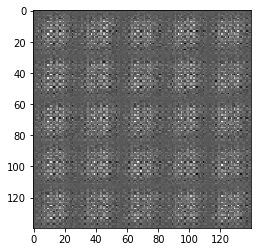

Batch: 1 - Discriminator Loss: 32.24645233154297 - Generator Loss: 12.04768180847168
Batch: 2 - Discriminator Loss: 1.7196660041809082 - Generator Loss: 26.11787223815918
Batch: 3 - Discriminator Loss: 9.613465309143066 - Generator Loss: 3.8966445922851562
Batch: 4 - Discriminator Loss: 20.99848175048828 - Generator Loss: 19.178850173950195
Batch: 5 - Discriminator Loss: 0.903251588344574 - Generator Loss: 16.240570068359375
Batch: 6 - Discriminator Loss: 0.6041884422302246 - Generator Loss: 9.747090339660645
Batch: 7 - Discriminator Loss: 1.0163688659667969 - Generator Loss: 21.282196044921875
Batch: 8 - Discriminator Loss: 2.1565699577331543 - Generator Loss: 11.582258224487305
Batch: 9 - Discriminator Loss: 7.129147052764893 - Generator Loss: 26.858062744140625
Batch: 10 - Discriminator Loss: 2.508418083190918 - Generator Loss: 20.649263381958008
Batch: 11 - Discriminator Loss: 0.8735339045524597 - Generator Loss: 8.10200309753418
Batch: 12 - Discriminator Loss: 9.339763641357422 - 

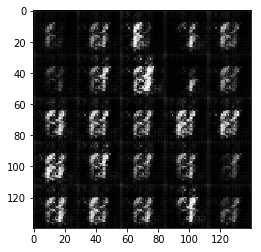

Batch: 101 - Discriminator Loss: 4.439578533172607 - Generator Loss: 7.032184600830078
Batch: 102 - Discriminator Loss: 0.6438549160957336 - Generator Loss: 2.724876642227173
Batch: 103 - Discriminator Loss: 0.8459619879722595 - Generator Loss: 4.247536659240723
Batch: 104 - Discriminator Loss: 0.5186617374420166 - Generator Loss: 3.295520782470703
Batch: 105 - Discriminator Loss: 0.5675290822982788 - Generator Loss: 2.8091981410980225
Batch: 106 - Discriminator Loss: 0.5711337327957153 - Generator Loss: 2.964716911315918
Batch: 107 - Discriminator Loss: 0.5896223783493042 - Generator Loss: 2.316420555114746
Batch: 108 - Discriminator Loss: 0.6010684967041016 - Generator Loss: 3.5455105304718018
Batch: 109 - Discriminator Loss: 0.556653618812561 - Generator Loss: 2.464848279953003
Batch: 110 - Discriminator Loss: 0.5611968636512756 - Generator Loss: 4.464973449707031
Batch: 111 - Discriminator Loss: 0.647140622138977 - Generator Loss: 2.0966687202453613
Batch: 112 - Discriminator Loss:

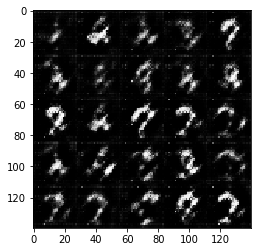

Batch: 201 - Discriminator Loss: 0.5262547135353088 - Generator Loss: 3.6234922409057617
Batch: 202 - Discriminator Loss: 0.5573859810829163 - Generator Loss: 4.904238700866699
Batch: 203 - Discriminator Loss: 0.5958418846130371 - Generator Loss: 2.1750593185424805
Batch: 204 - Discriminator Loss: 0.9224910140037537 - Generator Loss: 10.457554817199707
Batch: 205 - Discriminator Loss: 2.5389862060546875 - Generator Loss: 1.1511564254760742
Batch: 206 - Discriminator Loss: 1.4153789281845093 - Generator Loss: 5.331526756286621
Batch: 207 - Discriminator Loss: 0.40509989857673645 - Generator Loss: 4.564586639404297
Batch: 208 - Discriminator Loss: 0.44963186979293823 - Generator Loss: 3.0219321250915527
Batch: 209 - Discriminator Loss: 0.651214599609375 - Generator Loss: 4.553720951080322
Batch: 210 - Discriminator Loss: 0.5720816254615784 - Generator Loss: 2.078364849090576
Batch: 211 - Discriminator Loss: 0.9329996109008789 - Generator Loss: 8.530054092407227
Batch: 212 - Discriminator

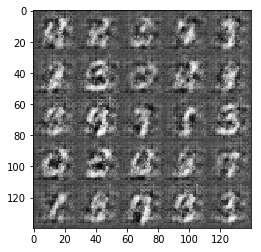

Batch: 301 - Discriminator Loss: 0.7423993349075317 - Generator Loss: 3.0923190116882324
Batch: 302 - Discriminator Loss: 0.6507969498634338 - Generator Loss: 2.179304599761963
Batch: 303 - Discriminator Loss: 0.6613975763320923 - Generator Loss: 3.7607879638671875
Batch: 304 - Discriminator Loss: 0.5488864779472351 - Generator Loss: 2.4731099605560303
Batch: 305 - Discriminator Loss: 0.7066212892532349 - Generator Loss: 3.7288641929626465
Batch: 306 - Discriminator Loss: 0.6258017420768738 - Generator Loss: 2.928156852722168
Batch: 307 - Discriminator Loss: 0.5582968592643738 - Generator Loss: 3.6466000080108643
Batch: 308 - Discriminator Loss: 0.4567931294441223 - Generator Loss: 3.3529744148254395
Batch: 309 - Discriminator Loss: 0.5548024773597717 - Generator Loss: 3.297767162322998
Batch: 310 - Discriminator Loss: 0.5230205655097961 - Generator Loss: 2.6477651596069336
Batch: 311 - Discriminator Loss: 0.42699122428894043 - Generator Loss: 3.120635986328125
Batch: 312 - Discriminat

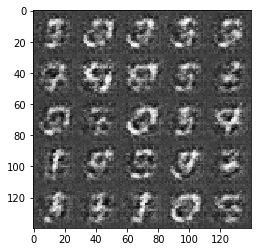

Batch: 401 - Discriminator Loss: 0.49137651920318604 - Generator Loss: 3.9060497283935547
Batch: 402 - Discriminator Loss: 0.520725667476654 - Generator Loss: 3.1200976371765137
Batch: 403 - Discriminator Loss: 0.570167064666748 - Generator Loss: 1.4087430238723755
Batch: 404 - Discriminator Loss: 0.763801634311676 - Generator Loss: 4.848222732543945
Batch: 405 - Discriminator Loss: 0.6538556218147278 - Generator Loss: 3.1038267612457275
Batch: 406 - Discriminator Loss: 0.7081331610679626 - Generator Loss: 1.2248616218566895
Batch: 407 - Discriminator Loss: 1.3070590496063232 - Generator Loss: 6.293092250823975
Batch: 408 - Discriminator Loss: 2.6457927227020264 - Generator Loss: 2.2102737426757812
Batch: 409 - Discriminator Loss: 0.9183059930801392 - Generator Loss: 2.4257965087890625
Batch: 410 - Discriminator Loss: 1.300067663192749 - Generator Loss: 1.3301236629486084
Batch: 411 - Discriminator Loss: 1.084820032119751 - Generator Loss: 4.726100921630859
Batch: 412 - Discriminator L

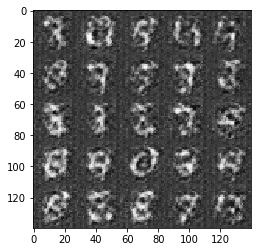

Batch: 1 - Discriminator Loss: 2.873382091522217 - Generator Loss: 8.142205238342285
Batch: 2 - Discriminator Loss: 2.9409263134002686 - Generator Loss: 1.709122896194458
Batch: 3 - Discriminator Loss: 1.0507681369781494 - Generator Loss: 3.959444999694824
Batch: 4 - Discriminator Loss: 0.5188999176025391 - Generator Loss: 2.793630599975586
Batch: 5 - Discriminator Loss: 0.5109233856201172 - Generator Loss: 2.947327136993408
Batch: 6 - Discriminator Loss: 0.4966118335723877 - Generator Loss: 2.6942203044891357
Batch: 7 - Discriminator Loss: 0.4899926781654358 - Generator Loss: 2.8911542892456055
Batch: 8 - Discriminator Loss: 0.5217474699020386 - Generator Loss: 3.0241026878356934
Batch: 9 - Discriminator Loss: 0.528578519821167 - Generator Loss: 2.687328815460205
Batch: 10 - Discriminator Loss: 0.5771450996398926 - Generator Loss: 3.4334166049957275
Batch: 11 - Discriminator Loss: 0.48201966285705566 - Generator Loss: 2.649278402328491
Batch: 12 - Discriminator Loss: 0.379507273435592

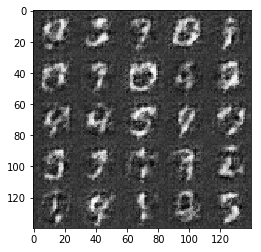

Batch: 101 - Discriminator Loss: 1.951735019683838 - Generator Loss: 2.273555278778076
Batch: 102 - Discriminator Loss: 0.8107300996780396 - Generator Loss: 1.0925707817077637
Batch: 103 - Discriminator Loss: 0.8792983889579773 - Generator Loss: 2.7037289142608643
Batch: 104 - Discriminator Loss: 1.2908225059509277 - Generator Loss: 0.5605980157852173
Batch: 105 - Discriminator Loss: 1.666134238243103 - Generator Loss: 3.7495999336242676
Batch: 106 - Discriminator Loss: 1.7043769359588623 - Generator Loss: 0.7467609643936157
Batch: 107 - Discriminator Loss: 1.3763182163238525 - Generator Loss: 3.2258012294769287
Batch: 108 - Discriminator Loss: 1.1181588172912598 - Generator Loss: 1.0892431735992432
Batch: 109 - Discriminator Loss: 0.936007022857666 - Generator Loss: 3.014665126800537
Batch: 110 - Discriminator Loss: 0.7798455953598022 - Generator Loss: 1.6200485229492188
Batch: 111 - Discriminator Loss: 0.6311914324760437 - Generator Loss: 2.960965871810913
Batch: 112 - Discriminator 

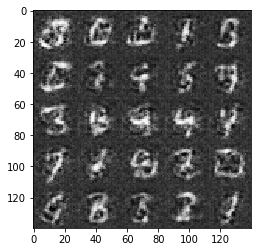

Batch: 201 - Discriminator Loss: 0.5596775412559509 - Generator Loss: 2.3807973861694336
Batch: 202 - Discriminator Loss: 0.5275892615318298 - Generator Loss: 2.8242404460906982
Batch: 203 - Discriminator Loss: 0.4772711992263794 - Generator Loss: 3.010047674179077
Batch: 204 - Discriminator Loss: 0.40814122557640076 - Generator Loss: 3.2589645385742188
Batch: 205 - Discriminator Loss: 0.47977912425994873 - Generator Loss: 3.0064711570739746
Batch: 206 - Discriminator Loss: 0.4998514950275421 - Generator Loss: 2.905935764312744
Batch: 207 - Discriminator Loss: 0.40296339988708496 - Generator Loss: 3.192579746246338
Batch: 208 - Discriminator Loss: 0.4677489697933197 - Generator Loss: 3.6323232650756836
Batch: 209 - Discriminator Loss: 0.42088475823402405 - Generator Loss: 3.490260362625122
Batch: 210 - Discriminator Loss: 0.3652813136577606 - Generator Loss: 3.7248692512512207
Batch: 211 - Discriminator Loss: 0.4464742839336395 - Generator Loss: 3.6002073287963867
Batch: 212 - Discrimi

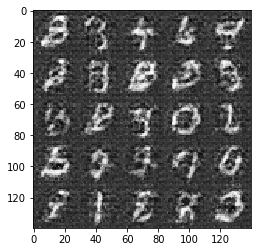

Batch: 301 - Discriminator Loss: 0.3647960126399994 - Generator Loss: 3.6235108375549316
Batch: 302 - Discriminator Loss: 0.36632949113845825 - Generator Loss: 4.043506622314453
Batch: 303 - Discriminator Loss: 0.3727510869503021 - Generator Loss: 3.4674906730651855
Batch: 304 - Discriminator Loss: 0.375564306974411 - Generator Loss: 3.470412492752075
Batch: 305 - Discriminator Loss: 0.3570247292518616 - Generator Loss: 4.071822166442871
Batch: 306 - Discriminator Loss: 0.35051941871643066 - Generator Loss: 4.309000492095947
Batch: 307 - Discriminator Loss: 0.34805572032928467 - Generator Loss: 4.4463090896606445
Batch: 308 - Discriminator Loss: 0.3532162308692932 - Generator Loss: 4.100744247436523
Batch: 309 - Discriminator Loss: 0.3478947877883911 - Generator Loss: 4.493598461151123
Batch: 310 - Discriminator Loss: 0.3576582670211792 - Generator Loss: 3.813319444656372
Batch: 311 - Discriminator Loss: 0.3630964159965515 - Generator Loss: 3.9716343879699707
Batch: 312 - Discriminator

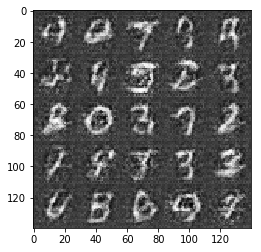

Batch: 401 - Discriminator Loss: 0.6292486190795898 - Generator Loss: 2.786207675933838
Batch: 402 - Discriminator Loss: 0.5706520676612854 - Generator Loss: 3.0763330459594727
Batch: 403 - Discriminator Loss: 0.5337601900100708 - Generator Loss: 2.831240177154541
Batch: 404 - Discriminator Loss: 0.4032893776893616 - Generator Loss: 3.1760306358337402
Batch: 405 - Discriminator Loss: 0.43220847845077515 - Generator Loss: 3.372992992401123
Batch: 406 - Discriminator Loss: 0.4327797293663025 - Generator Loss: 2.9519691467285156
Batch: 407 - Discriminator Loss: 0.38540881872177124 - Generator Loss: 3.3296306133270264
Batch: 408 - Discriminator Loss: 0.4312842786312103 - Generator Loss: 2.9708504676818848
Batch: 409 - Discriminator Loss: 0.414579302072525 - Generator Loss: 3.285583734512329
Batch: 410 - Discriminator Loss: 0.4083977937698364 - Generator Loss: 2.9839301109313965
Batch: 411 - Discriminator Loss: 0.47503042221069336 - Generator Loss: 3.85646915435791
Batch: 412 - Discriminato

In [12]:
batch_size = 128
z_dim = 200
learning_rate = .0005
beta1 = 0.2

tf.reset_default_graph()


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Batch: 0 - Discriminator Loss: 1.5910073518753052 - Generator Loss: 4.018526077270508


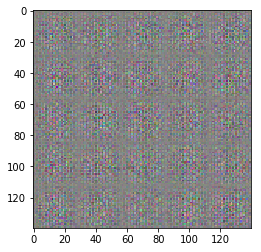

Batch: 1 - Discriminator Loss: 1.9303936958312988 - Generator Loss: 6.129825115203857
Batch: 2 - Discriminator Loss: 0.722758948802948 - Generator Loss: 4.977033615112305
Batch: 3 - Discriminator Loss: 0.9464470148086548 - Generator Loss: 6.457293510437012
Batch: 4 - Discriminator Loss: 0.684099555015564 - Generator Loss: 3.784621477127075
Batch: 5 - Discriminator Loss: 1.4507375955581665 - Generator Loss: 10.095303535461426
Batch: 6 - Discriminator Loss: 1.0759360790252686 - Generator Loss: 5.428717613220215
Batch: 7 - Discriminator Loss: 1.4722115993499756 - Generator Loss: 9.055559158325195
Batch: 8 - Discriminator Loss: 0.610279381275177 - Generator Loss: 6.372529983520508
Batch: 9 - Discriminator Loss: 0.7123308181762695 - Generator Loss: 6.141205787658691
Batch: 10 - Discriminator Loss: 0.7548408508300781 - Generator Loss: 4.380594253540039
Batch: 11 - Discriminator Loss: 0.8543722033500671 - Generator Loss: 10.733011245727539
Batch: 12 - Discriminator Loss: 1.0455085039138794 - 

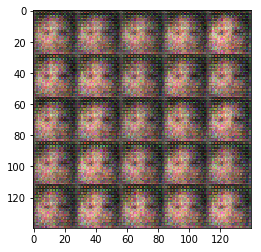

Batch: 101 - Discriminator Loss: 0.5844960808753967 - Generator Loss: 9.164155960083008
Batch: 102 - Discriminator Loss: 0.6265826225280762 - Generator Loss: 4.926739692687988
Batch: 103 - Discriminator Loss: 0.4446641504764557 - Generator Loss: 4.176939964294434
Batch: 104 - Discriminator Loss: 0.464701771736145 - Generator Loss: 6.061408042907715
Batch: 105 - Discriminator Loss: 0.4806799292564392 - Generator Loss: 3.065657377243042
Batch: 106 - Discriminator Loss: 0.5792282819747925 - Generator Loss: 10.53384780883789
Batch: 107 - Discriminator Loss: 1.0231413841247559 - Generator Loss: 4.035360336303711
Batch: 108 - Discriminator Loss: 0.549935519695282 - Generator Loss: 5.17689847946167
Batch: 109 - Discriminator Loss: 0.4573954641819 - Generator Loss: 5.394969940185547
Batch: 110 - Discriminator Loss: 0.4487963318824768 - Generator Loss: 4.26376485824585
Batch: 111 - Discriminator Loss: 0.454843133687973 - Generator Loss: 5.17051362991333
Batch: 112 - Discriminator Loss: 0.446020

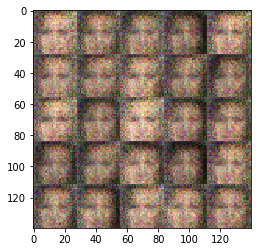

Batch: 201 - Discriminator Loss: 1.1950280666351318 - Generator Loss: 9.576391220092773
Batch: 202 - Discriminator Loss: 2.627089262008667 - Generator Loss: 2.9015390872955322
Batch: 203 - Discriminator Loss: 0.6731013059616089 - Generator Loss: 4.074189186096191
Batch: 204 - Discriminator Loss: 0.5480361580848694 - Generator Loss: 3.823765754699707
Batch: 205 - Discriminator Loss: 0.601615846157074 - Generator Loss: 3.357675075531006
Batch: 206 - Discriminator Loss: 0.695547878742218 - Generator Loss: 3.6697030067443848
Batch: 207 - Discriminator Loss: 0.7804802656173706 - Generator Loss: 2.5354764461517334
Batch: 208 - Discriminator Loss: 0.8612717986106873 - Generator Loss: 5.214960098266602
Batch: 209 - Discriminator Loss: 0.9909647703170776 - Generator Loss: 2.4868874549865723
Batch: 210 - Discriminator Loss: 0.6771753430366516 - Generator Loss: 5.1869611740112305
Batch: 211 - Discriminator Loss: 0.5718460083007812 - Generator Loss: 2.9541473388671875
Batch: 212 - Discriminator Lo

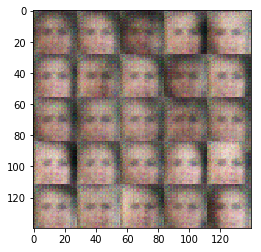

Batch: 301 - Discriminator Loss: 0.6708382964134216 - Generator Loss: 2.2888505458831787
Batch: 302 - Discriminator Loss: 0.6597006320953369 - Generator Loss: 3.0028204917907715
Batch: 303 - Discriminator Loss: 0.4997519254684448 - Generator Loss: 2.9406321048736572
Batch: 304 - Discriminator Loss: 0.674257218837738 - Generator Loss: 3.1674861907958984
Batch: 305 - Discriminator Loss: 0.6712732315063477 - Generator Loss: 1.8178751468658447
Batch: 306 - Discriminator Loss: 0.8075946569442749 - Generator Loss: 4.126821041107178
Batch: 307 - Discriminator Loss: 0.7153655290603638 - Generator Loss: 2.6275839805603027
Batch: 308 - Discriminator Loss: 0.8289244771003723 - Generator Loss: 4.020507335662842
Batch: 309 - Discriminator Loss: 0.8335390686988831 - Generator Loss: 1.7119450569152832
Batch: 310 - Discriminator Loss: 0.8752750754356384 - Generator Loss: 4.262028217315674
Batch: 311 - Discriminator Loss: 0.8714961409568787 - Generator Loss: 2.2165374755859375
Batch: 312 - Discriminato

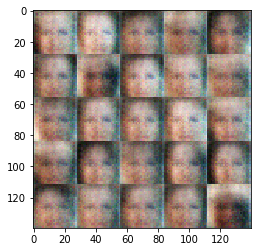

Batch: 401 - Discriminator Loss: 0.5271376371383667 - Generator Loss: 3.053879976272583
Batch: 402 - Discriminator Loss: 0.51886385679245 - Generator Loss: 3.344850778579712
Batch: 403 - Discriminator Loss: 0.53192138671875 - Generator Loss: 2.8283262252807617
Batch: 404 - Discriminator Loss: 0.5231714248657227 - Generator Loss: 3.6224420070648193
Batch: 405 - Discriminator Loss: 0.5086705684661865 - Generator Loss: 2.644906997680664
Batch: 406 - Discriminator Loss: 0.5939844846725464 - Generator Loss: 4.481527805328369
Batch: 407 - Discriminator Loss: 0.5345063805580139 - Generator Loss: 2.8052539825439453
Batch: 408 - Discriminator Loss: 0.723563015460968 - Generator Loss: 4.905887603759766
Batch: 409 - Discriminator Loss: 0.78078693151474 - Generator Loss: 2.0155439376831055
Batch: 410 - Discriminator Loss: 1.0956758260726929 - Generator Loss: 6.133231163024902
Batch: 411 - Discriminator Loss: 1.5746920108795166 - Generator Loss: 1.1891555786132812
Batch: 412 - Discriminator Loss: 1

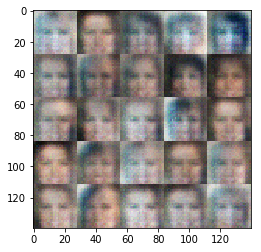

Batch: 501 - Discriminator Loss: 0.5679596662521362 - Generator Loss: 2.6192896366119385
Batch: 502 - Discriminator Loss: 0.5485498905181885 - Generator Loss: 2.660963535308838
Batch: 503 - Discriminator Loss: 0.5074390769004822 - Generator Loss: 2.54168701171875
Batch: 504 - Discriminator Loss: 0.647849440574646 - Generator Loss: 3.923879384994507
Batch: 505 - Discriminator Loss: 0.6927860975265503 - Generator Loss: 1.9271435737609863
Batch: 506 - Discriminator Loss: 1.26259446144104 - Generator Loss: 6.359448432922363
Batch: 507 - Discriminator Loss: 1.6592092514038086 - Generator Loss: 2.22683048248291
Batch: 508 - Discriminator Loss: 0.5381151437759399 - Generator Loss: 2.411261558532715
Batch: 509 - Discriminator Loss: 0.4768187999725342 - Generator Loss: 2.7985620498657227
Batch: 510 - Discriminator Loss: 0.514546275138855 - Generator Loss: 3.004753589630127
Batch: 511 - Discriminator Loss: 0.5482485294342041 - Generator Loss: 2.474411964416504
Batch: 512 - Discriminator Loss: 0.

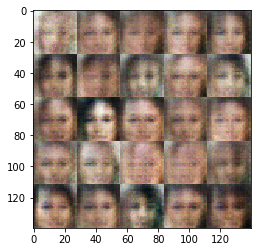

Batch: 601 - Discriminator Loss: 0.37836983799934387 - Generator Loss: 3.888918399810791
Batch: 602 - Discriminator Loss: 0.5219731330871582 - Generator Loss: 3.9604835510253906
Batch: 603 - Discriminator Loss: 0.4773433804512024 - Generator Loss: 3.139080762863159
Batch: 604 - Discriminator Loss: 0.5800427794456482 - Generator Loss: 5.2924981117248535
Batch: 605 - Discriminator Loss: 0.5871493816375732 - Generator Loss: 3.482977867126465
Batch: 606 - Discriminator Loss: 0.7617496252059937 - Generator Loss: 6.820871353149414
Batch: 607 - Discriminator Loss: 0.8758794665336609 - Generator Loss: 3.3149490356445312
Batch: 608 - Discriminator Loss: 0.6649972200393677 - Generator Loss: 4.628875732421875
Batch: 609 - Discriminator Loss: 0.46440088748931885 - Generator Loss: 3.9320297241210938
Batch: 610 - Discriminator Loss: 0.532929539680481 - Generator Loss: 3.697141170501709
Batch: 611 - Discriminator Loss: 0.5264018774032593 - Generator Loss: 2.7081124782562256
Batch: 612 - Discriminator

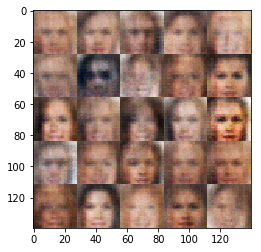

Batch: 701 - Discriminator Loss: 0.7336606979370117 - Generator Loss: 4.520721435546875
Batch: 702 - Discriminator Loss: 0.4519558548927307 - Generator Loss: 5.16014289855957
Batch: 703 - Discriminator Loss: 0.5855872631072998 - Generator Loss: 3.041893482208252
Batch: 704 - Discriminator Loss: 0.462792307138443 - Generator Loss: 3.0319876670837402
Batch: 705 - Discriminator Loss: 0.3971412777900696 - Generator Loss: 3.364506483078003
Batch: 706 - Discriminator Loss: 0.37636247277259827 - Generator Loss: 4.082801818847656
Batch: 707 - Discriminator Loss: 0.9058313369750977 - Generator Loss: 6.480751991271973
Batch: 708 - Discriminator Loss: 1.427903175354004 - Generator Loss: 1.2542221546173096
Batch: 709 - Discriminator Loss: 1.436629295349121 - Generator Loss: 7.215390205383301
Batch: 710 - Discriminator Loss: 1.8536239862442017 - Generator Loss: 1.5512735843658447
Batch: 711 - Discriminator Loss: 1.0275148153305054 - Generator Loss: 5.2184953689575195
Batch: 712 - Discriminator Loss

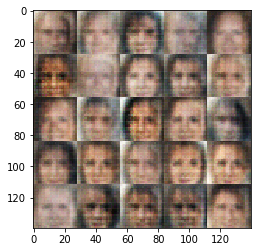

Batch: 801 - Discriminator Loss: 0.47365137934684753 - Generator Loss: 3.259617567062378
Batch: 802 - Discriminator Loss: 0.3810565769672394 - Generator Loss: 3.5380396842956543
Batch: 803 - Discriminator Loss: 0.3655696213245392 - Generator Loss: 4.885696887969971
Batch: 804 - Discriminator Loss: 0.6812021732330322 - Generator Loss: 4.987123489379883
Batch: 805 - Discriminator Loss: 1.1214582920074463 - Generator Loss: 0.7935023307800293
Batch: 806 - Discriminator Loss: 1.7056480646133423 - Generator Loss: 8.510650634765625
Batch: 807 - Discriminator Loss: 2.755551815032959 - Generator Loss: 3.6443886756896973
Batch: 808 - Discriminator Loss: 0.43875300884246826 - Generator Loss: 2.9315154552459717
Batch: 809 - Discriminator Loss: 0.6267392635345459 - Generator Loss: 4.158495903015137
Batch: 810 - Discriminator Loss: 0.9989646077156067 - Generator Loss: 1.0935577154159546
Batch: 811 - Discriminator Loss: 2.8543736934661865 - Generator Loss: 7.947542190551758
Batch: 812 - Discriminator

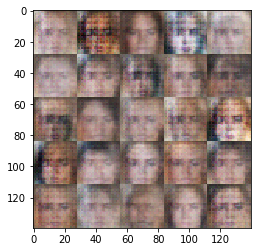

Batch: 901 - Discriminator Loss: 0.45553073287010193 - Generator Loss: 3.6667847633361816
Batch: 902 - Discriminator Loss: 0.5001786351203918 - Generator Loss: 3.775547981262207
Batch: 903 - Discriminator Loss: 0.3966899812221527 - Generator Loss: 4.0241899490356445
Batch: 904 - Discriminator Loss: 0.4512102007865906 - Generator Loss: 3.900988817214966
Batch: 905 - Discriminator Loss: 0.4333063066005707 - Generator Loss: 3.457998037338257
Batch: 906 - Discriminator Loss: 0.5076306462287903 - Generator Loss: 4.637210845947266
Batch: 907 - Discriminator Loss: 0.48363998532295227 - Generator Loss: 3.9954073429107666
Batch: 908 - Discriminator Loss: 0.49336767196655273 - Generator Loss: 4.080774784088135
Batch: 909 - Discriminator Loss: 0.4010925889015198 - Generator Loss: 4.211917877197266
Batch: 910 - Discriminator Loss: 0.4340113401412964 - Generator Loss: 3.480238914489746
Batch: 911 - Discriminator Loss: 0.37175729870796204 - Generator Loss: 4.19600772857666
Batch: 912 - Discriminator

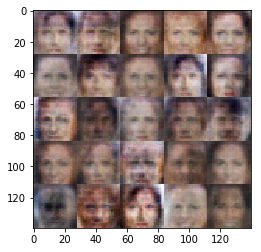

Batch: 1001 - Discriminator Loss: 0.6701560020446777 - Generator Loss: 4.266671180725098
Batch: 1002 - Discriminator Loss: 0.7041885852813721 - Generator Loss: 1.985828161239624
Batch: 1003 - Discriminator Loss: 0.4692822992801666 - Generator Loss: 3.3494231700897217
Batch: 1004 - Discriminator Loss: 0.35031208395957947 - Generator Loss: 6.256880760192871
Batch: 1005 - Discriminator Loss: 0.6202903389930725 - Generator Loss: 3.709092855453491
Batch: 1006 - Discriminator Loss: 0.5820326209068298 - Generator Loss: 2.477623224258423
Batch: 1007 - Discriminator Loss: 0.38117295503616333 - Generator Loss: 3.6868016719818115
Batch: 1008 - Discriminator Loss: 0.37079134583473206 - Generator Loss: 4.7141313552856445
Batch: 1009 - Discriminator Loss: 0.383703351020813 - Generator Loss: 3.8402960300445557
Batch: 1010 - Discriminator Loss: 0.3648713529109955 - Generator Loss: 5.920751571655273
Batch: 1011 - Discriminator Loss: 0.9057672619819641 - Generator Loss: 6.095342636108398
Batch: 1012 - D

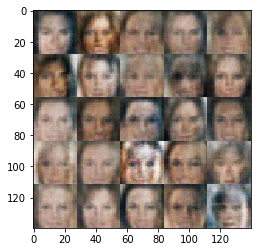

Batch: 1101 - Discriminator Loss: 2.0870144367218018 - Generator Loss: 5.279155254364014
Batch: 1102 - Discriminator Loss: 0.5168816447257996 - Generator Loss: 4.040126323699951
Batch: 1103 - Discriminator Loss: 0.4117533266544342 - Generator Loss: 4.625925064086914
Batch: 1104 - Discriminator Loss: 0.9220116138458252 - Generator Loss: 6.397684097290039
Batch: 1105 - Discriminator Loss: 1.7472054958343506 - Generator Loss: 1.1855814456939697
Batch: 1106 - Discriminator Loss: 1.7212848663330078 - Generator Loss: 6.690611839294434
Batch: 1107 - Discriminator Loss: 1.168049693107605 - Generator Loss: 4.429375648498535
Batch: 1108 - Discriminator Loss: 0.8726974129676819 - Generator Loss: 3.7963309288024902
Batch: 1109 - Discriminator Loss: 0.5586402416229248 - Generator Loss: 2.5941760540008545
Batch: 1110 - Discriminator Loss: 0.5258708596229553 - Generator Loss: 2.675043821334839
Batch: 1111 - Discriminator Loss: 0.4481934905052185 - Generator Loss: 3.0566458702087402
Batch: 1112 - Disc

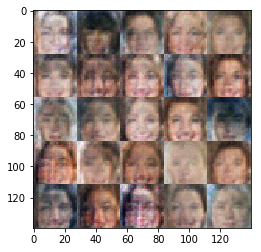

Batch: 1201 - Discriminator Loss: 0.47977131605148315 - Generator Loss: 4.232747554779053
Batch: 1202 - Discriminator Loss: 0.46305927634239197 - Generator Loss: 7.952633380889893
Batch: 1203 - Discriminator Loss: 0.5641011595726013 - Generator Loss: 4.58347225189209
Batch: 1204 - Discriminator Loss: 0.4800559878349304 - Generator Loss: 9.0437593460083
Batch: 1205 - Discriminator Loss: 0.41587719321250916 - Generator Loss: 3.5160045623779297
Batch: 1206 - Discriminator Loss: 0.359342485666275 - Generator Loss: 6.600033283233643
Batch: 1207 - Discriminator Loss: 0.4497252106666565 - Generator Loss: 3.4328012466430664
Batch: 1208 - Discriminator Loss: 0.37734532356262207 - Generator Loss: 7.354822635650635
Batch: 1209 - Discriminator Loss: 0.553850531578064 - Generator Loss: 4.4531636238098145
Batch: 1210 - Discriminator Loss: 0.5736423134803772 - Generator Loss: 4.843526840209961
Batch: 1211 - Discriminator Loss: 0.3668158948421478 - Generator Loss: 6.732918739318848
Batch: 1212 - Discr

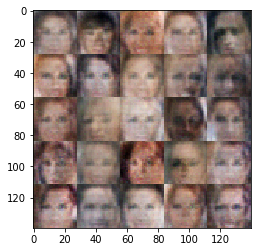

Batch: 1301 - Discriminator Loss: 0.43109986186027527 - Generator Loss: 3.3473551273345947
Batch: 1302 - Discriminator Loss: 0.3706389367580414 - Generator Loss: 4.810832500457764
Batch: 1303 - Discriminator Loss: 0.4147096276283264 - Generator Loss: 3.3084216117858887
Batch: 1304 - Discriminator Loss: 0.360990971326828 - Generator Loss: 5.367768287658691
Batch: 1305 - Discriminator Loss: 0.5875741839408875 - Generator Loss: 4.0773115158081055
Batch: 1306 - Discriminator Loss: 0.5191314816474915 - Generator Loss: 5.294683933258057
Batch: 1307 - Discriminator Loss: 0.3613267242908478 - Generator Loss: 4.0853071212768555
Batch: 1308 - Discriminator Loss: 0.3545404076576233 - Generator Loss: 6.449865818023682
Batch: 1309 - Discriminator Loss: 0.570469856262207 - Generator Loss: 3.759464740753174
Batch: 1310 - Discriminator Loss: 0.4471116364002228 - Generator Loss: 6.6026153564453125
Batch: 1311 - Discriminator Loss: 0.3624216914176941 - Generator Loss: 4.516116142272949
Batch: 1312 - Dis

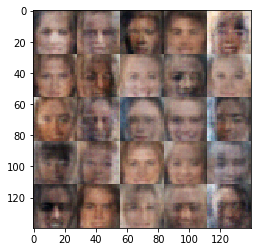

Batch: 1401 - Discriminator Loss: 0.5484247207641602 - Generator Loss: 2.4871292114257812
Batch: 1402 - Discriminator Loss: 0.40334606170654297 - Generator Loss: 3.4176025390625
Batch: 1403 - Discriminator Loss: 0.5976149439811707 - Generator Loss: 2.9146764278411865
Batch: 1404 - Discriminator Loss: 0.4739198088645935 - Generator Loss: 3.006086826324463
Batch: 1405 - Discriminator Loss: 0.6117844581604004 - Generator Loss: 3.443457841873169
Batch: 1406 - Discriminator Loss: 0.5460450649261475 - Generator Loss: 3.6429431438446045
Batch: 1407 - Discriminator Loss: 0.6166818737983704 - Generator Loss: 3.8681583404541016
Batch: 1408 - Discriminator Loss: 0.4308745861053467 - Generator Loss: 5.169873237609863
Batch: 1409 - Discriminator Loss: 0.8569250106811523 - Generator Loss: 4.148866653442383
Batch: 1410 - Discriminator Loss: 0.8630087971687317 - Generator Loss: 2.212188243865967
Batch: 1411 - Discriminator Loss: 0.3976891040802002 - Generator Loss: 3.7394516468048096
Batch: 1412 - Dis

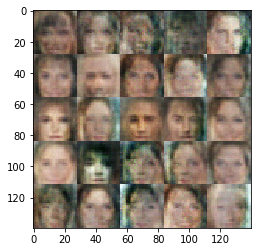

Batch: 1501 - Discriminator Loss: 0.34692350029945374 - Generator Loss: 6.284221172332764
Batch: 1502 - Discriminator Loss: 0.6775591373443604 - Generator Loss: 4.619361400604248
Batch: 1503 - Discriminator Loss: 0.8803071975708008 - Generator Loss: 3.931847095489502
Batch: 1504 - Discriminator Loss: 0.3979930281639099 - Generator Loss: 5.229686737060547
Batch: 1505 - Discriminator Loss: 0.428500771522522 - Generator Loss: 4.133301734924316
Batch: 1506 - Discriminator Loss: 0.3537706732749939 - Generator Loss: 5.943861961364746
Batch: 1507 - Discriminator Loss: 0.47156861424446106 - Generator Loss: 3.4795806407928467
Batch: 1508 - Discriminator Loss: 0.4190523326396942 - Generator Loss: 6.314289569854736
Batch: 1509 - Discriminator Loss: 0.7539688348770142 - Generator Loss: 4.062502861022949
Batch: 1510 - Discriminator Loss: 0.6623717546463013 - Generator Loss: 4.516852855682373
Batch: 1511 - Discriminator Loss: 0.3531925082206726 - Generator Loss: 5.144258499145508
Batch: 1512 - Discr

In [13]:
batch_size = 128
z_dim = 200
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.